### 比鸡
流传于安徽、江浙一带的民间扑克游戏，在常州溧阳地区尤为流行，2到5人玩，
每位玩家发9张牌，每3张牌一组，搭成牌形由小到大的三组牌相互比较大小。

### Biji
Biji is a popular game in southeast china, with players 2-5, everyone get 9 cards and group them into three sets with 3 cards each. Start with smallest set, the player compare the sets with other players.

Create cards and poker class

In [1]:
class Card(object):
    """一张牌"""
    suite_repre = {3:'♠',2:'♥',1:'♣',0:'♦'}
    face_repre = {2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'10',11:'J',12:'Q',13:'K',14:'A'}
    def __init__(self, suite, face):
        self.suite = suite #花色
        self.face = face # 面
        self.statev = max(self.face-9,1) # CLASS OF STATE eaqual 1 if facev<=10 
    
    def __lt__(self,other):
        return([self.face,self.suite]<[other.face,other.suite])
    
    def __eq__(self,other):
         return([self.face,self.suite]==[other.face,other.suite])

    def __str__(self):
        return '%s%s' % (self.suite_repre[self.suite], self.face_repre[self.face])
    
    def __repr__(self):
        return self.__str__()

In [2]:
print(Card(3,14),Card(3,14)<Card(3,14))

♠A False


In [3]:
class Poker(object):
    """一副牌"""
    def __init__(self):
        self._cards = [Card(suite, face) for suite in range(4) for face in range(2, 15)]
        self._current = 0

    @property
    def cards(self):
        return self._cards

    def shuffle(self):
        """洗牌(随机乱序)"""
        self._current = 0
        random.shuffle(self._cards)

    def next(self,n):
        """发n张牌"""
        cards = self._cards[self._current:self._current+n]
        self._current += n
        return cards

In [4]:
import random
p=Poker()
print(p.next(9))

[♦2, ♦3, ♦4, ♦5, ♦6, ♦7, ♦8, ♦9, ♦10]


In [5]:
dummy=Card(0,0)
class ThreeCards(object):
    '''三张牌'''
    def __init__(self,cards):
        self.cards = cards
        self.zha = 0 # three of same face '♠A,♥A,♣A'
        self.shunqin = dummy # three of same suite and connected face '♣3,♣2,♣A' < '♦4,♦3,♦2' < '♣A,♣K,♣Q'
        self.qin = [0,0,0,dummy] # three of same suite '♦J,♦8,♦3' 
        self.shun = dummy # connected face '♦2,♣3,♦4'
        self.dui = [0,dummy] # 2 of same face '♦2,♣2,♦4'
        self.dan = [0,0,0,dummy] # most common type '♣A,♣8,♦4'
        self.isqin = (len(set([card.suite for card in self.cards]))==1)
        self.eval()
        self._value = [self.zha,self.shunqin,self.qin,self.shun,self.dui,self.dan] #compare order of cards

    def eval(self):
        self.cards.sort(reverse=True) #sort from large to small
        f1,f2,f3 = [card.face for card in self.cards]
        if f1 == f3:
            self.zha = f1
            return
        elif f1 == f2:
            self.dui = [f2,self.cards[-1]] #(对，单)
            return
        elif f2 == f3:
            self.cards = self.cards[1:]+[self.cards[0]] #change order,pair first
            self.dui = [f2,self.cards[-1]] #(对，单)
            return
        elif f1-1==f2 and f2-1==f3:
            self.shun = self.cards[0]
        elif f1==14 and f2==3 and f3==2:
            self.cards = self.cards[1:]+[self.cards[0]] #change order
            self.shun = self.cards[0]
        else:
            self.dan = [self.cards[0].face, self.cards[1].face,self.cards[2].face,self.cards[0]]
        if self.isqin:
            self.shunqin = self.shun
            self.qin = self.dan   
        return
        
    def __lt__(self,other):
        return self._value<other._value
    
    def __eq__(self,other):
        return self._value==other._value

    def __str__(self):
        return '(%s, %s, %s)' % (self.cards[0],self.cards[1],self.cards[2])

    def __repr__(self):
        return self.__str__()

In [6]:
cards1 = p.next(3)
cards2 = p.next(3)
threecards1 = ThreeCards(cards1)
threecards2 = ThreeCards(cards2)
print(threecards1,threecards2,threecards1>threecards2)

(♦K, ♦Q, ♦J) (♣3, ♣2, ♦A) True


In [15]:
from itertools import permutations,combinations

perms = set(permutations([0,0,0,1,1,1,2,2,2]))
# get all group combination of nine cards into separated list

def perm_set(nine_cards): 
    for perm in perms:
        cards = [[],[],[]]
        for i,p in enumerate(perm):
            cards[p].append(nine_cards[i])
        cardset = [ThreeCards(x) for x in cards]
        cardset.sort() #sort the sets from small to large
        yield cardset

In [16]:
from operator import itemgetter

class Player(object):
    """玩家"""
    def __init__(self, name):
        self.name = name
        self._cards_on_hand = []
        self.money = 0

    def get(self, cards):
        """摸牌"""
        self._cards_on_hand+=cards

    def clean(self):
        self._cards_on_hand = []

    def arrange(self):
        """玩家整理手上的牌"""
        sortedchoices= []
        choices = list(perm_set(self._cards_on_hand)) #all permutation choices
        for (i,j,k) in permutations([0,1,2]):
            max_choice=max(choices,key=itemgetter(i,j,k))
            sortedchoices.append(max_choice)
        return sortedchoices
    
    def pickone(self,sortedchoices,strategy):
        return strategy.pick(sortedchoices)

    def addgain(self,gain):
        self.money+=gain

In [17]:
player = Player('东邪')
player.clean()
p=Poker()
p.shuffle()
player.get(p.next(9))
print(player.arrange())

[[(♥Q, ♦J, ♥10), (♠9, ♠8, ♠3), (♥J, ♥7, ♥3)], [(♥Q, ♦J, ♥10), (♠9, ♠8, ♠3), (♥J, ♥7, ♥3)], [(♥Q, ♦J, ♥10), (♠9, ♠8, ♠3), (♥J, ♥7, ♥3)], [(♦J, ♥7, ♥3), (♠9, ♠8, ♠3), (♥Q, ♥J, ♥10)], [(♠3, ♥3, ♦J), (♠9, ♠8, ♥7), (♥Q, ♥J, ♥10)], [(♦J, ♥7, ♥3), (♠9, ♠8, ♠3), (♥Q, ♥J, ♥10)]]


In [18]:
p=Poker()

#print(len(set(list(combinations(cards,3))))) #22100 states, which is too many 
#we need to reduce the states

all_combination = sorted([ThreeCards(list(x)) for x in combinations(p.cards,3)])

all_state = [[y.face for y in x.cards] for x in all_combination]
index=[]
i=-1
laststate = (0,0,0)
for state in all_state:
    if state==laststate:
        pass
    else:
        i+=1
        laststate=state
    index.append(i)
    
print(len(set(index))) # 741 states in total after ignore suite
all_combination = [str(x.cards) for x in all_combination]
state_to_index = dict(zip(all_combination,index))
#print(state_to_index)

741


In [20]:
print(state_to_index)

{'[♦5, ♣3, ♦2]': 0, '[♦5, ♥3, ♦2]': 0, '[♦5, ♠3, ♦2]': 0, '[♦5, ♦3, ♣2]': 0, '[♦5, ♦3, ♥2]': 0, '[♦5, ♦3, ♠2]': 0, '[♦5, ♣3, ♣2]': 0, '[♦5, ♥3, ♣2]': 0, '[♦5, ♠3, ♣2]': 0, '[♦5, ♣3, ♥2]': 0, '[♦5, ♣3, ♠2]': 0, '[♦5, ♥3, ♥2]': 0, '[♦5, ♠3, ♥2]': 0, '[♦5, ♥3, ♠2]': 0, '[♦5, ♠3, ♠2]': 0, '[♣5, ♦3, ♦2]': 0, '[♣5, ♣3, ♦2]': 0, '[♣5, ♥3, ♦2]': 0, '[♣5, ♠3, ♦2]': 0, '[♣5, ♦3, ♣2]': 0, '[♣5, ♦3, ♥2]': 0, '[♣5, ♦3, ♠2]': 0, '[♣5, ♥3, ♣2]': 0, '[♣5, ♠3, ♣2]': 0, '[♣5, ♣3, ♥2]': 0, '[♣5, ♣3, ♠2]': 0, '[♣5, ♥3, ♥2]': 0, '[♣5, ♠3, ♥2]': 0, '[♣5, ♥3, ♠2]': 0, '[♣5, ♠3, ♠2]': 0, '[♥5, ♦3, ♦2]': 0, '[♥5, ♣3, ♦2]': 0, '[♥5, ♥3, ♦2]': 0, '[♥5, ♠3, ♦2]': 0, '[♥5, ♦3, ♣2]': 0, '[♥5, ♦3, ♥2]': 0, '[♥5, ♦3, ♠2]': 0, '[♥5, ♣3, ♣2]': 0, '[♥5, ♥3, ♣2]': 0, '[♥5, ♠3, ♣2]': 0, '[♥5, ♣3, ♥2]': 0, '[♥5, ♣3, ♠2]': 0, '[♥5, ♠3, ♥2]': 0, '[♥5, ♥3, ♠2]': 0, '[♥5, ♠3, ♠2]': 0, '[♠5, ♦3, ♦2]': 0, '[♠5, ♣3, ♦2]': 0, '[♠5, ♥3, ♦2]': 0, '[♠5, ♠3, ♦2]': 0, '[♠5, ♦3, ♣2]': 0, '[♠5, ♦3, ♥2]': 0, '[♠5, ♦3, ♠2]': 0, '[♠5, ♣3, ♣

In [21]:
import numpy as np

class States_value(object): 
    '''record rank possibility of all states'''
    def __init__(self):
        self.num_people = gameinfo.get('num_people')
        self.loadweight()
        
    def loadweight(self):
        print('loading weight...')
        try:
            self.count = np.load('count_'+str(self.num_people)+'.npy')
            self.rankholder = np.load('rankholder_'+str(self.num_people)+'.npy')
        except:
            self.count = np.zeros((741,3))
            self.rankholder = np.zeros((741,3,self.num_people)) #states,set order, rank probability

    def saveweight(self):
        print('saving weight...')
        np.save('count_'+str(self.num_people)+'.npy',self.count)
        np.save('rankholder_'+str(self.num_people)+'.npy',self.rankholder)
        print('done')
    
    def get_state(self,threecards):
        return state_to_index[str(threecards.cards)]
    
    def get_rate(self,threecards,r):
        state = self.get_state(threecards)
        return self.rankholder[state,r]
    
    def update(self,threecards,r,rank):
        state = self.get_state(threecards)
        self.count[state,r] += 1
        R=np.zeros(self.num_people)
        R[rank] = 1
        self.rankholder[state,r] += 1/self.count[state,r] * (R-self.rankholder[state,r])
        # Q = Q + 1/n(R-Q)    
    
    def get_maxratediff(self,oldstate_rate):
        return np.max(np.abs(self.rankholder-oldstate_rate))

    def get_report(self):
        report=self.rankholder.reshape(-1,3*self.num_people).round(2)
        return report
    

In [22]:
class Reward(object):
    gainrule = {5:np.array([10,-1,-2,-3,-4]),4:np.array([6,-1,-2,-3]),3:np.array([3,-1,-2]),2:np.array([1,-1])}
    def __init__(self):
        self.num_people = gameinfo.get('num_people')
        self.gain = self.gainrule[self.num_people]
    
    def get_reward(self,rank):
        return self.gain[rank]
    
    def get_total_reward(self,ranks):
        return sum([self.get_reward(rank) for rank in ranks])
    
    def get_expected(self,ranks):
        return sum(self.gain*ranks)

In [23]:
class RLagent(object):
    '''Reinforcement learning strategy epsilon-greedy'''
    '''USE Asynchronous Dynamic Programming'''
    def __init__(self,States,Reward,epsilon=0.1):
        self.num_people = gameinfo.get('num_people')
        self.epsilon = epsilon # explore rate
        self.States = States
        self.Reward = Reward

    def pick(self,choices):
        q_values = self.qvalues(choices)
        if np.random.random()<self.epsilon:
            action = np.random.choice(range(6))
        else:
            action = np.argmax(q_values)
        return action, q_values[action]

    def qvalues(self,choices):
        qvalues=[]
        for choice in choices:
            expected_reward = 0
            for r,threecards in enumerate(choice):
                rankrate = self.States.get_rate(threecards,r)
                expected_reward += self.Reward.get_expected(rankrate)
            qvalues.append(expected_reward)
        return qvalues

    def update_State(self,results,dicission):
        for r,ranks in enumerate(results):
            for i,rank in enumerate(ranks):
                threecards = dicission[i][r]
                self.States.update(threecards,r,rank)

    def greedy_choice(self,choice):
        q_values = self.qvalues(choice)
        action = np.argmax(q_values)
        return action

In [24]:
class Play(object):
    def __init__(self):
        self.p = Poker()
        self.rounds=0
        self.player_number =  gameinfo.get('num_people')
        self.players = [Player(u'东邪'), Player(u'西毒'), Player(u'南帝'), Player(u'北丐'),Player(u'中神')][:self.player_number]
        self.States = States_value()
        self.Reward = Reward()
        self.agent = RLagent(self.States,self.Reward)

    def OneRound(self):
        self.p.shuffle()
        self.record=[]
        for i,player in enumerate(self.players):
            player.clean()
            player.get(self.p.next(9))
        decission = []
        for player in self.players:
            choices = player.arrange()
            action,expected_reward = self.agent.pick(choices)
            decission.append(choices[action])
            self.record.append([player.name,action,choices[action],expected_reward.round(1)])
        results = self.judge(decission)
        for i,result in enumerate(np.transpose(results)):
            gain = self.Reward.get_total_reward(result)
            self.record[i]+=[result,gain]
            self.players[i].addgain(gain)
        self.agent.update_State(results,decission)
        self.rounds+=1

    def getexample(self):
        print()
        for record in self.record:
            print(record)
        
    @staticmethod
    def judge(dicission):
        results=[]
        l = len(dicission)
        for r in range(3):
            rank=[0]*l
            sortedrank = [i[0] for i in sorted(enumerate(dicission),key=lambda x: x[1][r],reverse=True)]
            for i,n in enumerate(sortedrank):
                rank[n]=i
            results.append(rank)
        return results

In [34]:
import time
from tqdm import tqdm
from copy import copy

start = time.time()
gameinfo = {'num_people':5}

play = Play()
rounds=30000
oldstate_rate = copy(play.States.rankholder)

maxdiff = []
money = [[] for i in range(play.player_number)]
R = []
divs=[]
diviation = 0 
for i in tqdm(range(rounds),ascii=True,ncols=70):
    play.OneRound()
    diviation+=sum((np.array(play.record)[:,-1]-np.array(play.record)[:,-3])**2)
    if i%1000==999:
        play.getexample()
        maxdiff.append(play.States.get_maxratediff(oldstate_rate))
        R.append(i)
        divs.append(diviation/1000)
        for p,player in enumerate(play.players):
            money[p].append(player.money)
        
        oldstate_rate = copy(play.States.rankholder)
        diviation=0

for player in play.players:
    print(player.name,'win',player.money)

play.States.saveweight()
end = time.time()
print('time used:',end-start)


loading weight...


  3%|8                          | 999/30000 [03:04<1:29:29,  5.40it/s]


['东邪', 2, [(♠A, ♠8, ♥3), (♣10, ♣3, ♣2), (♦10, ♦6, ♦5)], -5.7, array([2, 2, 3]), -7]
['西毒', 3, [(♣8, ♦7, ♠5), (♥J, ♥10, ♥4), (♣A, ♣K, ♣9)], 1.4, array([4, 1, 1]), -6]
['南帝', 0, [(♥5, ♣5, ♠K), (♠10, ♦9, ♦8), (♠9, ♠4, ♠3)], -3.4, array([0, 3, 4]), 3]
['北丐', 0, [(♦A, ♥9, ♦3), (♥8, ♠7, ♥6), (♣Q, ♣J, ♣4)], -5.7, array([1, 4, 2]), -7]
['中神', 2, [(♠J, ♣7, ♦4), (♥A, ♥K, ♥7), (♠Q, ♥Q, ♦Q)], 15.6, array([3, 0, 0]), 17]


  7%|#7                        | 1999/30000 [06:09<1:24:52,  5.50it/s]


['东邪', 0, [(♠6, ♦6, ♠8), (♣4, ♥3, ♣2), (♣A, ♣J, ♣9)], -2.5, array([3, 2, 2]), -7]
['西毒', 0, [(♦K, ♦7, ♦2), (♥K, ♥J, ♥9), (♠Q, ♠J, ♠10)], 21.3, array([0, 0, 1]), 19]
['南帝', 0, [(♥Q, ♣Q, ♦10), (♠5, ♦4, ♠3), (♥10, ♥8, ♥6)], -2.5, array([1, 1, 4]), -6]
['北丐', 4, [(♥7, ♣7, ♦9), (♣8, ♦8, ♥5), (♠A, ♥A, ♦A)], 8.9, array([2, 3, 0]), 5]
['中神', 4, [(♦Q, ♠9, ♦5), (♠4, ♥4, ♥2), (♣K, ♣10, ♣5)], -9.4, array([4, 4, 3]), -11]


 10%|##5                       | 2999/30000 [09:13<1:24:29,  5.33it/s]


['东邪', 4, [(♦J, ♠9, ♣7), (♣K, ♠6, ♦2), (♥K, ♥5, ♥4)], -9.4, array([2, 4, 3]), -9]
['西毒', 0, [(♣5, ♦5, ♥3), (♥A, ♠K, ♣Q), (♣10, ♣9, ♣3)], -4.3, array([1, 3, 4]), -8]
['南帝', 2, [(♣J, ♥9, ♣6), (♠7, ♠3, ♠2), (♦K, ♦10, ♦3)], -6.8, array([3, 2, 2]), -7]
['北丐', 2, [(♥7, ♦6, ♦4), (♠Q, ♠J, ♠5), (♣A, ♣8, ♣4)], -1.8, array([4, 1, 1]), -6]
['中神', 0, [(♥Q, ♥8, ♥6), (♠A, ♠10, ♠4), (♦A, ♦Q, ♦7)], 19.9, array([0, 0, 0]), 30]


 13%|###4                      | 3999/30000 [12:18<1:19:50,  5.43it/s]


['东邪', 0, [(♠A, ♦A, ♠4), (♣10, ♥9, ♣8), (♥Q, ♥7, ♥3)], -1.1, array([2, 3, 4]), -9]
['西毒', 2, [(♠K, ♠7, ♥2), (♦J, ♦5, ♦4), (♣A, ♣5, ♣2)], -4.4, array([4, 2, 2]), -8]
['南帝', 0, [(♦K, ♥10, ♣3), (♥J, ♣J, ♠2), (♦8, ♦7, ♦6)], -2.9, array([3, 4, 1]), -8]
['北丐', 4, [(♦10, ♦3, ♦2), (♥A, ♥K, ♥8), (♠Q, ♣Q, ♦Q)], 28.8, array([0, 0, 0]), 30]
['中神', 0, [(♣6, ♥5, ♥4), (♠J, ♠8, ♠6), (♣K, ♣9, ♣4)], 5.6, array([1, 1, 3]), -5]


 17%|####3                     | 4999/30000 [15:23<1:17:36,  5.37it/s]


['东邪', 1, [(♥10, ♦10, ♥8), (♠Q, ♦Q, ♦5), (♣Q, ♣J, ♣7)], -3.9, array([2, 4, 3]), -9]
['西毒', 2, [(♦8, ♣5, ♦3), (♠J, ♠9, ♠3), (♥K, ♥J, ♥6)], -5.3, array([4, 2, 2]), -8]
['南帝', 0, [(♠6, ♠5, ♣4), (♠K, ♠8, ♠4), (♦A, ♦9, ♦2)], 10.3, array([0, 1, 1]), 8]
['北丐', 3, [(♦J, ♦7, ♥3), (♣A, ♣6, ♣2), (♥A, ♥Q, ♥5)], 5.4, array([3, 0, 0]), 17]
['中神', 0, [(♠10, ♣10, ♦K), (♦4, ♣3, ♠2), (♥9, ♥7, ♥4)], -3.9, array([1, 3, 4]), -8]


 20%|#####1                    | 5999/30000 [18:28<1:13:22,  5.45it/s]


['东邪', 0, [(♠5, ♠4, ♠2), (♣8, ♣5, ♣2), (♦9, ♦4, ♦2)], 4.2, array([0, 2, 3]), 5]
['西毒', 0, [(♣10, ♦10, ♣Q), (♠K, ♦K, ♦8), (♥9, ♥5, ♥3)], -3.9, array([2, 4, 2]), -8]
['南帝', 0, [(♥A, ♣A, ♠Q), (♣7, ♣6, ♦5), (♣K, ♥Q, ♠J)], -0.6, array([1, 3, 4]), -8]
['北丐', 2, [(♣3, ♦3, ♣J), (♠10, ♠8, ♠7), (♥K, ♥J, ♥6)], -2.1, array([3, 0, 0]), 17]
['中神', 3, [(♠A, ♦6, ♠3), (♥10, ♥4, ♥2), (♦Q, ♦J, ♦7)], -4.9, array([4, 1, 1]), -6]


 23%|######                    | 6999/30000 [21:32<1:14:12,  5.17it/s]


['东邪', 2, [(♦A, ♦8, ♠5), (♣10, ♣9, ♠8), (♥J, ♥9, ♥2)], -7.3, array([1, 3, 4]), -8]
['西毒', 2, [(♥7, ♣6, ♣2), (♠K, ♠9, ♠6), (♦K, ♦J, ♦2)], -0.5, array([4, 1, 1]), -6]
['南帝', 0, [(♣K, ♥8, ♦6), (♣5, ♦5, ♥3), (♠Q, ♠10, ♠2)], -9.5, array([2, 4, 3]), -9]
['北丐', 2, [(♠A, ♣Q, ♣J), (♦Q, ♦9, ♦4), (♥K, ♥6, ♥5)], -0.8, array([0, 2, 2]), 6]
['中神', 2, [(♠J, ♥4, ♦3), (♣A, ♣4, ♣3), (♠7, ♣7, ♦7)], 10.1, array([3, 0, 0]), 17]


 27%|######9                   | 7999/30000 [24:37<1:07:37,  5.42it/s]


['东邪', 2, [(♠8, ♣8, ♠9), (♥A, ♥J, ♥6), (♦A, ♦J, ♦9)], 9.5, array([1, 1, 3]), -5]
['西毒', 2, [(♣J, ♦8, ♦5), (♥5, ♥4, ♥3), (♥9, ♥8, ♥7)], 9.1, array([3, 0, 1]), 6]
['南帝', 2, [(♠2, ♥2, ♠3), (♣K, ♣7, ♣5), (♥Q, ♣Q, ♦Q)], 11.3, array([2, 2, 0]), 6]
['北丐', 2, [(♥10, ♣9, ♦2), (♠4, ♦3, ♣2), (♠7, ♠6, ♠5)], -3.9, array([4, 3, 2]), -9]
['中神', 2, [(♠10, ♦10, ♣6), (♠A, ♣A, ♥K), (♦7, ♦6, ♦4)], -4.1, array([0, 4, 4]), 2]


 30%|#######7                  | 8999/30000 [27:42<1:03:38,  5.50it/s]


['东邪', 2, [(♥A, ♦K, ♦8), (♣5, ♠4, ♠3), (♠J, ♠10, ♠8)], -7.2, array([1, 4, 4]), -9]
['西毒', 2, [(♠A, ♦A, ♣7), (♥Q, ♥J, ♥4), (♠2, ♥2, ♦2)], 13.9, array([0, 1, 0]), 19]
['南帝', 2, [(♠Q, ♦6, ♠5), (♥9, ♥7, ♥6), (♣A, ♣K, ♣10)], -2.5, array([2, 3, 2]), -7]
['北丐', 2, [(♦10, ♠9, ♦5), (♣J, ♣9, ♣6), (♥K, ♥10, ♥3)], -5.1, array([3, 2, 3]), -8]
['中神', 2, [(♦7, ♥5, ♦4), (♦Q, ♦J, ♦9), (♣4, ♣3, ♣2)], 1.7, array([4, 0, 1]), 5]


 33%|########6                 | 9999/30000 [30:46<1:01:23,  5.43it/s]


['东邪', 0, [(♥7, ♦7, ♣J), (♥8, ♣8, ♥3), (♠K, ♠10, ♠3)], -4.3, array([1, 2, 1]), -4]
['西毒', 0, [(♥A, ♣A, ♠9), (♣K, ♣6, ♣3), (♦K, ♦Q, ♦8)], 8.3, array([0, 0, 0]), 30]
['南帝', 2, [(♦A, ♥5, ♦4), (♥Q, ♠J, ♣10), (♠Q, ♠5, ♠2)], -7.4, array([3, 1, 2]), -6]
['北丐', 4, [(♠A, ♣9, ♠7), (♥2, ♦2, ♥4), (♦J, ♦9, ♦3)], -8.8, array([2, 4, 3]), -9]
['中神', 0, [(♥K, ♠8, ♠6), (♥6, ♦6, ♣5), (♥10, ♦10, ♣2)], -10.3, array([4, 3, 4]), -11]


 37%|#########8                 | 10999/30000 [33:51<58:42,  5.39it/s]


['东邪', 2, [(♥A, ♣7, ♥6), (♣K, ♣J, ♣9), (♠10, ♣10, ♦10)], 11.9, array([4, 0, 0]), 16]
['西毒', 3, [(♥2, ♦2, ♠7), (♦K, ♦9, ♦8), (♠K, ♠J, ♠8)], 1.6, array([3, 1, 3]), -7]
['南帝', 0, [(♣5, ♠4, ♦3), (♠6, ♦5, ♣4), (♣Q, ♣3, ♣2)], 0.5, array([0, 4, 4]), 2]
['北丐', 4, [(♠A, ♦A, ♣8), (♠Q, ♠5, ♠2), (♥10, ♥9, ♥8)], 11.6, array([1, 2, 2]), -5]
['中神', 4, [(♣6, ♦6, ♦7), (♥7, ♥5, ♥3), (♥K, ♥Q, ♥J)], 3.5, array([2, 3, 1]), -6]


 40%|##########7                | 11999/30000 [36:56<55:41,  5.39it/s]


['东邪', 0, [(♦4, ♠3, ♣2), (♠8, ♦7, ♣6), (♥K, ♥6, ♥5)], 1.1, array([0, 1, 3]), 6]
['西毒', 2, [(♦A, ♣10, ♥8), (♥Q, ♥J, ♥9), (♠A, ♠J, ♠6)], 2.1, array([3, 0, 2]), 5]
['南帝', 1, [(♠5, ♦5, ♠Q), (♣9, ♦9, ♦2), (♣A, ♣J, ♣8)], -2.6, array([2, 4, 1]), -7]
['北丐', 0, [(♥7, ♣7, ♦Q), (♦6, ♣5, ♠4), (♥10, ♠9, ♦8)], -5.4, array([1, 2, 4]), -7]
['中神', 4, [(♦J, ♠10, ♠7), (♥4, ♦3, ♥2), (♠K, ♣K, ♦K)], 3.2, array([4, 3, 0]), 3]


 43%|###########6               | 12999/30000 [40:01<50:54,  5.57it/s]


['东邪', 2, [(♣Q, ♥8, ♥2), (♦6, ♣5, ♠4), (♠9, ♠6, ♠3)], -9.4, array([2, 2, 4]), -8]
['西毒', 4, [(♥J, ♦8, ♠7), (♥5, ♦4, ♣3), (♠K, ♥K, ♦K)], 3.2, array([3, 3, 1]), -7]
['南帝', 4, [(♣K, ♠10, ♦9), (♥4, ♣4, ♠5), (♦3, ♦2, ♦A)], -4.1, array([1, 4, 2]), -7]
['北丐', 2, [(♠J, ♥10, ♥9), (♦J, ♦10, ♦7), (♥Q, ♥7, ♥3)], 6.2, array([0, 0, 3]), 17]
['中神', 3, [(♣6, ♦5, ♣2), (♣J, ♣9, ♣8), (♠A, ♥A, ♣A)], 7.8, array([4, 1, 0]), 5]


 47%|############5              | 13999/30000 [43:00<47:49,  5.58it/s]


['东邪', 3, [(♦K, ♣5, ♠4), (♥9, ♥7, ♥3), (♠A, ♠8, ♠6)], -4.0, array([3, 0, 2]), 5]
['西毒', 0, [(♠10, ♥10, ♠5), (♦8, ♦6, ♦3), (♣A, ♣J, ♣2)], 0.7, array([0, 1, 1]), 8]
['南帝', 0, [(♣7, ♦7, ♦5), (♣K, ♠Q, ♦J), (♥A, ♥J, ♥2)], -1.0, array([1, 2, 0]), 7]
['北丐', 0, [(♦A, ♥K, ♦10), (♥8, ♣8, ♣6), (♠J, ♠3, ♠2)], -8.3, array([2, 4, 4]), -10]
['中神', 3, [(♠7, ♦4, ♦2), (♥5, ♣4, ♣3), (♣Q, ♣10, ♣9)], -9.5, array([4, 3, 3]), -10]


 50%|#############4             | 14999/30000 [45:59<44:10,  5.66it/s]


['东邪', 2, [(♣K, ♣10, ♠9), (♦10, ♦6, ♦4), (♥Q, ♥8, ♥6)], -5.5, array([2, 2, 3]), -7]
['西毒', 2, [(♦J, ♦5, ♣2), (♠Q, ♠8, ♠2), (♥A, ♥9, ♥7)], -2.0, array([4, 1, 1]), -6]
['南帝', 2, [(♥4, ♣4, ♠6), (♠K, ♦K, ♥J), (♥10, ♣9, ♦8)], -6.9, array([0, 3, 4]), 3]
['北丐', 4, [(♠A, ♣5, ♠4), (♦A, ♦9, ♥2), (♣Q, ♣J, ♣7)], -8.2, array([1, 4, 2]), -7]
['中神', 2, [(♥K, ♠10, ♠7), (♣A, ♣8, ♣6), (♠3, ♥3, ♣3)], 10.0, array([3, 0, 0]), 17]


 53%|##############3            | 15999/30000 [48:57<41:04,  5.68it/s]


['东邪', 0, [(♣5, ♥4, ♦3), (♦J, ♦10, ♠9), (♦A, ♦7, ♦2)], 3.2, array([1, 1, 3]), -5]
['西毒', 0, [(♠8, ♠6, ♠5), (♣9, ♣8, ♣2), (♠J, ♥J, ♣J)], 15.8, array([0, 0, 1]), 19]
['南帝', 0, [(♠4, ♦4, ♣A), (♠Q, ♦Q, ♣3), (♥9, ♥6, ♥5)], -6.8, array([2, 2, 4]), -8]
['北丐', 4, [(♥10, ♦8, ♠7), (♣Q, ♣4, ♥2), (♥K, ♣K, ♦K)], 2.0, array([4, 4, 0]), 2]
['中神', 4, [(♠K, ♣10, ♦5), (♣6, ♦6, ♠2), (♥A, ♥8, ♥3)], -7.0, array([3, 3, 2]), -8]


 57%|###############2           | 16999/30000 [51:57<39:29,  5.49it/s]


['东邪', 4, [(♦Q, ♣10, ♥7), (♥A, ♠4, ♦3), (♠8, ♥8, ♣8)], -0.2, array([4, 4, 0]), 2]
['西毒', 0, [(♣A, ♠10, ♠9), (♦8, ♦7, ♥6), (♣4, ♣3, ♣2)], -2.4, array([2, 2, 1]), -5]
['南帝', 2, [(♦A, ♣9, ♦4), (♠6, ♥5, ♥4), (♠K, ♥Q, ♣J)], -8.4, array([3, 3, 4]), -10]
['北丐', 0, [(♥K, ♣K, ♥10), (♠J, ♦10, ♦9), (♠7, ♠5, ♠2)], -1.2, array([0, 1, 3]), 6]
['中神', 0, [(♥J, ♦J, ♥3), (♠A, ♦K, ♠Q), (♣Q, ♣7, ♣5)], -2.5, array([1, 0, 2]), 7]


 60%|################1          | 17999/30000 [54:59<36:09,  5.53it/s]


['东邪', 0, [(♠10, ♥10, ♥9), (♥6, ♠5, ♥4), (♦K, ♦8, ♦3)], -3.4, array([0, 3, 3]), 4]
['西毒', 2, [(♠6, ♦6, ♠3), (♥K, ♥J, ♥2), (♣A, ♣K, ♣9)], 6.6, array([3, 0, 0]), 17]
['南帝', 2, [(♥Q, ♦10, ♥3), (♣J, ♣6, ♣5), (♠K, ♠J, ♠7)], -5.2, array([4, 2, 2]), -8]
['北丐', 0, [(♠9, ♦9, ♥7), (♦Q, ♦7, ♦5), (♦A, ♦4, ♦2)], 3.0, array([1, 1, 1]), -3]
['中神', 1, [(♠8, ♥8, ♦J), (♠4, ♣3, ♠2), (♣Q, ♣4, ♣2)], -4.6, array([2, 4, 4]), -10]


 63%|#################          | 18999/30000 [58:00<32:12,  5.69it/s]


['东邪', 0, [(♥2, ♦2, ♥5), (♦K, ♦9, ♦8), (♦A, ♦6, ♦3)], 2.9, array([3, 2, 2]), -7]
['西毒', 2, [(♥J, ♦5, ♥3), (♣K, ♣10, ♣2), (♠A, ♠10, ♠6)], 2.0, array([4, 1, 0]), 5]
['南帝', 0, [(♠4, ♣4, ♥A), (♠7, ♦7, ♥9), (♣J, ♦J, ♣3)], -7.5, array([2, 4, 4]), -10]
['北丐', 0, [(♥10, ♦10, ♣6), (♦4, ♠3, ♠2), (♥8, ♥7, ♥4)], -3.6, array([1, 3, 3]), -7]
['中神', 2, [(♥Q, ♦Q, ♠5), (♠K, ♠J, ♠8), (♣A, ♣8, ♣7)], 9.0, array([0, 0, 1]), 19]


 67%|################6        | 19999/30000 [1:01:00<29:32,  5.64it/s]


['东邪', 0, [(♣9, ♦9, ♦6), (♥Q, ♥10, ♥3), (♠4, ♥4, ♦4)], 9.1, array([2, 2, 0]), 6]
['西毒', 0, [(♣J, ♣7, ♣4), (♥K, ♥9, ♥7), (♦A, ♦J, ♦8)], 15.2, array([0, 0, 1]), 19]
['南帝', 0, [(♠6, ♥6, ♥J), (♦K, ♦3, ♦2), (♠K, ♠5, ♠3)], 1.0, array([3, 1, 3]), -7]
['北丐', 2, [(♥2, ♣2, ♦5), (♠10, ♠9, ♣8), (♣K, ♣10, ♣3)], -5.4, array([4, 3, 2]), -9]
['中神', 0, [(♠A, ♥A, ♣Q), (♦7, ♣6, ♥5), (♠Q, ♠J, ♠7)], 0.2, array([1, 4, 4]), -9]


 70%|#################4       | 20999/30000 [1:03:57<26:01,  5.77it/s]


['东邪', 0, [(♠10, ♣10, ♠8), (♥Q, ♣Q, ♦6), (♥J, ♥9, ♥2)], -3.9, array([0, 3, 3]), 4]
['西毒', 2, [(♠7, ♥7, ♦K), (♠5, ♦4, ♣3), (♣A, ♣K, ♣J)], -0.7, array([1, 2, 0]), 7]
['南帝', 0, [(♠3, ♦3, ♣9), (♥4, ♣4, ♥8), (♦A, ♦Q, ♦J)], -3.5, array([2, 4, 2]), -8]
['北丐', 2, [(♠A, ♥5, ♠2), (♣8, ♣6, ♣2), (♦10, ♦9, ♦7)], -7.0, array([3, 1, 4]), -8]
['中神', 2, [(♣5, ♠4, ♦2), (♠K, ♠9, ♠6), (♥A, ♥K, ♥10)], 2.6, array([4, 0, 1]), 5]


 73%|##################3      | 21999/30000 [1:06:55<23:40,  5.63it/s]


['东邪', 2, [(♦7, ♣6, ♥3), (♠8, ♠6, ♠3), (♠Q, ♥Q, ♦Q)], 3.8, array([4, 0, 0]), 16]
['西毒', 4, [(♦A, ♠7, ♥5), (♠10, ♦10, ♣3), (♠2, ♣2, ♦2)], -0.9, array([2, 3, 1]), -6]
['南帝', 4, [(♠K, ♠J, ♥10), (♥4, ♣4, ♦5), (♣A, ♣K, ♣J)], -4.2, array([3, 4, 2]), -9]
['北丐', 0, [(♣8, ♦8, ♣9), (♥K, ♦K, ♠5), (♥7, ♥6, ♥2)], -5.0, array([1, 2, 4]), -7]
['中神', 1, [(♣5, ♠4, ♦3), (♣10, ♠9, ♥8), (♥A, ♥J, ♥9)], 4.2, array([0, 1, 3]), 6]


 77%|###################1     | 22999/30000 [1:09:55<20:57,  5.57it/s]


['东邪', 0, [(♣J, ♦J, ♥A), (♠9, ♣8, ♦7), (♠A, ♠K, ♠3)], 2.2, array([0, 1, 1]), 8]
['西毒', 0, [(♠J, ♥J, ♣K), (♥4, ♣3, ♥2), (♦8, ♦6, ♦5)], -3.9, array([1, 3, 4]), -8]
['南帝', 2, [(♠6, ♣6, ♠8), (♥Q, ♥10, ♥7), (♣A, ♣Q, ♣10)], 3.7, array([2, 0, 2]), 6]
['北丐', 0, [(♠5, ♣5, ♥6), (♠4, ♦3, ♣2), (♦A, ♦K, ♦4)], -1.8, array([3, 2, 0]), 5]
['中神', 4, [(♦10, ♠7, ♥5), (♠Q, ♣4, ♦2), (♥K, ♥9, ♥8)], -9.5, array([4, 4, 3]), -11]


 80%|###################9     | 23999/30000 [1:12:53<18:24,  5.43it/s]


['东邪', 2, [(♦K, ♠9, ♠7), (♣J, ♣10, ♣3), (♠4, ♠3, ♠2)], 0.2, array([3, 1, 1]), -5]
['西毒', 5, [(♥4, ♣4, ♣2), (♠A, ♦A, ♠8), (♥J, ♥10, ♥6)], -6.5, array([1, 4, 3]), -8]
['南帝', 0, [(♠Q, ♣Q, ♣K), (♥9, ♥8, ♥3), (♦5, ♦4, ♦3)], 5.4, array([0, 2, 0]), 18]
['北丐', 2, [(♦Q, ♦J, ♠5), (♣A, ♣8, ♣7), (♥A, ♥Q, ♥7)], 5.2, array([4, 0, 2]), 4]
['中神', 0, [(♥2, ♦2, ♥K), (♦7, ♠6, ♥5), (♣9, ♣6, ♣5)], -6.8, array([2, 3, 4]), -9]


 83%|####################8    | 24999/30000 [1:15:53<15:48,  5.27it/s]


['东邪', 3, [(♦9, ♥8, ♥2), (♠4, ♦3, ♠2), (♠K, ♠Q, ♠6)], -8.6, array([4, 3, 4]), -11]
['西毒', 4, [(♥J, ♦10, ♠8), (♠3, ♣3, ♥7), (♣A, ♣K, ♣4)], -5.9, array([3, 4, 2]), -9]
['南帝', 0, [(♣J, ♣8, ♣2), (♥K, ♥10, ♥9), (♥5, ♥4, ♥3)], 17.2, array([0, 0, 1]), 19]
['北丐', 0, [(♠A, ♦K, ♦Q), (♣10, ♣9, ♣5), (♦A, ♦8, ♦7)], 8.0, array([1, 2, 3]), -6]
['中神', 3, [(♥A, ♠7, ♠5), (♦J, ♦5, ♦4), (♠J, ♠10, ♠9)], 2.1, array([2, 1, 0]), 7]


 87%|#####################6   | 25999/30000 [1:18:55<11:41,  5.70it/s]


['东邪', 0, [(♣6, ♣5, ♣2), (♠J, ♠4, ♠3), (♥K, ♥J, ♥3)], 6.8, array([0, 2, 2]), 6]
['西毒', 1, [(♠5, ♥5, ♣Q), (♥9, ♣9, ♥10), (♦4, ♦3, ♠2)], -7.2, array([2, 4, 4]), -10]
['南帝', 2, [(♦Q, ♠8, ♦2), (♥Q, ♥7, ♥2), (♣K, ♣8, ♣4)], -3.1, array([4, 1, 3]), -8]
['北丐', 2, [(♣A, ♦7, ♣3), (♦K, ♦10, ♦8), (♠A, ♠7, ♠6)], 1.6, array([3, 0, 0]), 17]
['中神', 1, [(♦6, ♦5, ♥4), (♣J, ♣10, ♠9), (♠K, ♠Q, ♠10)], 2.7, array([1, 3, 1]), -5]


 90%|######################4  | 26999/30000 [1:21:59<09:23,  5.33it/s]


['东邪', 2, [(♦K, ♠6, ♥2), (♣J, ♣7, ♣5), (♥Q, ♣Q, ♦Q)], 6.9, array([1, 1, 0]), 8]
['西毒', 4, [(♠4, ♦4, ♣K), (♦9, ♦8, ♠7), (♥K, ♥10, ♥7)], -4.7, array([0, 3, 3]), 4]
['南帝', 2, [(♠K, ♠5, ♥3), (♣8, ♦7, ♣6), (♦J, ♦10, ♦3)], -8.5, array([2, 4, 4]), -10]
['北丐', 2, [(♥6, ♣4, ♣2), (♥J, ♥9, ♥8), (♠A, ♠10, ♠3)], -3.4, array([4, 0, 1]), 5]
['中神', 3, [(♠9, ♥4, ♦2), (♣10, ♣9, ♠8), (♦A, ♦6, ♦5)], -7.2, array([3, 2, 2]), -7]


 93%|#######################3 | 27999/30000 [1:25:02<05:55,  5.63it/s]


['东邪', 2, [(♠Q, ♦6, ♠2), (♥J, ♥7, ♥6), (♣7, ♣6, ♣5)], 0.0, array([4, 1, 1]), -6]
['西毒', 2, [(♣Q, ♠9, ♥2), (♠5, ♦4, ♣3), (♦10, ♦7, ♦3)], -9.5, array([3, 2, 2]), -7]
['南帝', 0, [(♣2, ♦2, ♣10), (♣8, ♦8, ♠6), (♥9, ♥5, ♥3)], -8.1, array([1, 4, 3]), -8]
['北丐', 0, [(♠4, ♣4, ♠K), (♠10, ♥10, ♦Q), (♦9, ♠8, ♠7)], -7.3, array([0, 3, 4]), 3]
['中神', 3, [(♦A, ♣9, ♦5), (♥A, ♥8, ♥4), (♠J, ♣J, ♦J)], 14.5, array([2, 0, 0]), 18]


 97%|########################1| 28999/30000 [1:28:02<02:56,  5.69it/s]


['东邪', 3, [(♥A, ♦8, ♣3), (♠5, ♠4, ♠2), (♣K, ♣6, ♣5)], -6.1, array([3, 2, 2]), -7]
['西毒', 4, [(♣7, ♦7, ♣8), (♦10, ♦4, ♦2), (♠Q, ♥Q, ♣Q)], 9.5, array([1, 0, 0]), 19]
['南帝', 2, [(♠10, ♦9, ♣2), (♦Q, ♠J, ♣10), (♥K, ♥6, ♥2)], -7.9, array([4, 3, 3]), -10]
['北丐', 0, [(♥9, ♣9, ♦K), (♣J, ♦J, ♥5), (♠7, ♠6, ♠3)], -4.6, array([0, 4, 4]), 2]
['中神', 0, [(♥4, ♣4, ♥3), (♦6, ♦5, ♦3), (♠A, ♠K, ♠8)], -0.6, array([2, 1, 1]), -4]


100%|########################9| 29999/30000 [1:31:01<00:00,  5.54it/s]


['东邪', 4, [(♥Q, ♦10, ♦3), (♥9, ♠8, ♣7), (♣10, ♣9, ♣8)], -2.0, array([4, 3, 1]), -8]
['西毒', 0, [(♣K, ♦K, ♣3), (♥A, ♥J, ♥7), (♥2, ♣2, ♦2)], 17.4, array([2, 0, 0]), 18]
['南帝', 0, [(♣5, ♣4, ♥3), (♦Q, ♠J, ♠10), (♦A, ♦7, ♦4)], 3.1, array([1, 2, 2]), -5]
['北丐', 0, [(♠6, ♠4, ♠2), (♦9, ♦8, ♦6), (♥K, ♥10, ♥4)], 6.0, array([0, 1, 3]), 6]
['中神', 4, [(♣A, ♥8, ♥6), (♣J, ♦J, ♦5), (♠Q, ♠9, ♠5)], -8.1, array([3, 4, 4]), -11]


100%|#########################| 30000/30000 [1:31:01<00:00,  5.40it/s]


东邪 win 71
西毒 win 108
南帝 win 1880
北丐 win 880
中神 win -2939
saving weight...
done
time used: 5461.347234249115


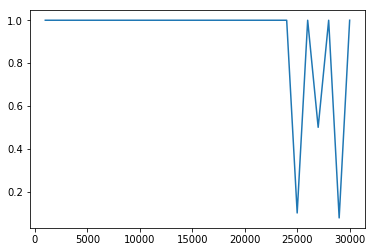

In [35]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.plot(R,maxdiff)
plt.show()

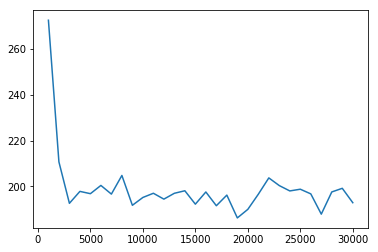

In [36]:
plt.plot(R,divs)
plt.show()

In [ ]:
#The diviartion between expection and real gain drops after 3000 rounds

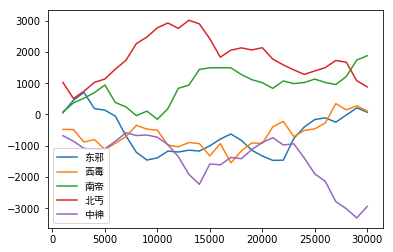

In [37]:
for i,row in enumerate(money):
    plt.plot(R,row,label=play.players[i].name)
plt.legend(prop = FontProperties('SimHei'))
plt.show()

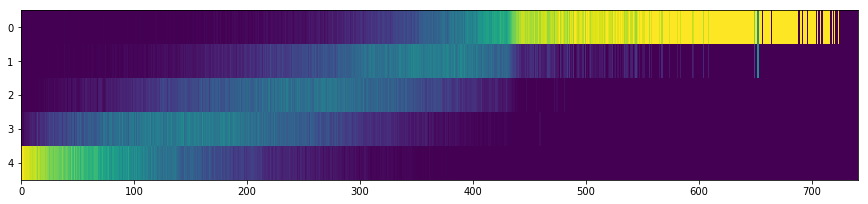

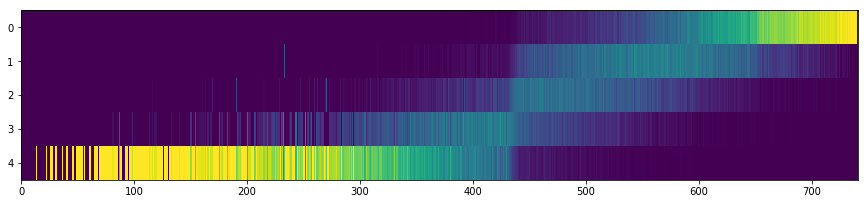

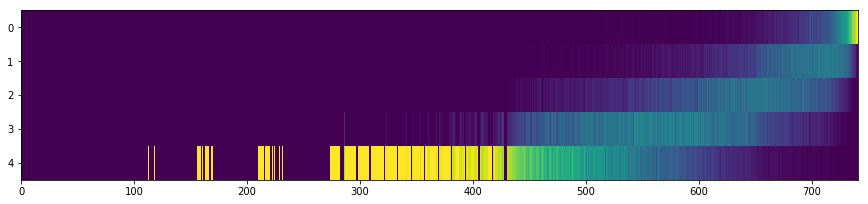

In [38]:
for r in [0,1,2]:
    fig, ax = plt.subplots(figsize=(15,5))
    ax.imshow(play.States.rankholder[:,r].swapaxes(0,1))
    ax.set_aspect(30)

###  this is how rank distribution with different states, 
### in round 1, when your cards is in top 50%, you have a large chance to win
### in round 2, you cards need to be in top 10%
### in round 3, your cards need to be in top 1% to win

# So, if you get nine cards, how would you group them?

In [39]:
p=Poker()
p.shuffle()
cards = p.next(9)
print(cards)

[♣3, ♦9, ♦10, ♠4, ♣10, ♦J, ♠6, ♠9, ♠K]


In [40]:
States = States_value()
reward = Reward()
agent = RLagent(States,reward)
player = Player('PC')
player.get(cards)
choices = player.arrange()
expected_win = agent.qvalues(choices)
for i,choice in enumerate(choices):
    print(choice,expected_win[i])

loading weight...
[(♠9, ♦9, ♦J), (♣10, ♦10, ♣3), (♠K, ♠6, ♠4)] -3.8707257620282505
[(♠9, ♦9, ♦J), (♣10, ♦10, ♣3), (♠K, ♠6, ♠4)] -3.8707257620282505
[(♣10, ♠4, ♣3), (♠K, ♠9, ♠6), (♦J, ♦10, ♦9)] 5.421670295369388
[(♣10, ♠4, ♣3), (♠K, ♠9, ♠6), (♦J, ♦10, ♦9)] 5.421670295369388
[(♠K, ♣10, ♣3), (♠9, ♠6, ♠4), (♦J, ♦10, ♦9)] 0.6025838549217646
[(♣10, ♠4, ♣3), (♠K, ♠9, ♠6), (♦J, ♦10, ♦9)] 5.421670295369388
